<a href="https://colab.research.google.com/github/Siddharth02003/CS6910_assignment_2/blob/main/CS6910_assignment_2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import torch.nn.init
import torch.optim as optim


In [2]:
!pip install wandb -qqq
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00


In [3]:
!wandb login --relogin
entity_name="siddharth-s"

project_name="FODL_Assignment_2A"

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip 

--2023-04-12 13:27:31--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G  21.3MB/s    in 2m 49s  

2023-04-12 13:30:21 (21.5 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



In [5]:
!unzip /content/nature_12K.zip

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [6]:
def image_info(path):
  for folder in os.listdir(path):
      imgs=glob.glob((path+'/'+folder+'/*'))
      print("Number of images in",folder,len(imgs))


In [7]:
image_info('/content/inaturalist_12K/train')

Number of images in Arachnida 1000
Number of images in Animalia 1000
Number of images in Amphibia 1000
Number of images in Aves 1000
Number of images in Mollusca 1000
Number of images in Mammalia 1000
Number of images in Fungi 999
Number of images in Insecta 1000
Number of images in .DS_Store 0
Number of images in Plantae 1000
Number of images in Reptilia 1000


In [8]:
image_info('/content/inaturalist_12K/val')

Number of images in Arachnida 200
Number of images in Animalia 200
Number of images in Amphibia 200
Number of images in Aves 200
Number of images in Mollusca 200
Number of images in Mammalia 200
Number of images in Fungi 200
Number of images in Insecta 200
Number of images in Plantae 200
Number of images in Reptilia 200


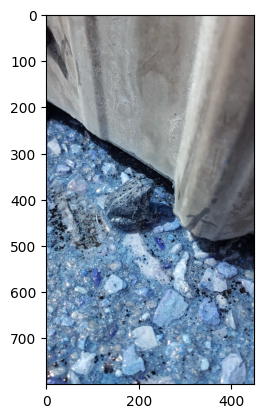

In [9]:
import cv2 as cv
img=cv.imread('/content/inaturalist_12K/train/Amphibia/015f03767b5fd30019df9ca7720cb869.jpg')
img.shape
plt.imshow(img)


In [10]:
class prepare_data():

  def __init__(self,augment=True,batch_size=16):
    self.train_path='/content/inaturalist_12K/train'
    self.test_path='/content/inaturalist_12K/val'
    self.augment=augment
    self.batch_size=batch_size

  def prepare(self,):
    if self.augment==True:
       train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation((120)),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.5),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

       test_transforms = transforms.Compose([transforms.RandomRotation(120),
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    else:
       train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),                               
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

       test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


    train_data = datasets.ImageFolder(self.train_path, transform=train_transforms) 
    test_data = datasets.ImageFolder(self.test_path, transform=test_transforms)

    num_workers = 0
    valid_size = 0.2
    num_train = len(train_data)
    indices = list(range(num_train))
    num_train_class=1000
    split = int(np.floor(valid_size * num_train_class))
    train_id=[]
    valid_id=[]
    for i in range(10):
      x=i+1
      train_idx, valid_idx = indices[i*1000+split:x*1000], indices[i*1000:i*1000+split]
      train_id=train_id+train_idx
      valid_id=valid_id+valid_idx

    train_sampler = SubsetRandomSampler(train_id)
    valid_sampler = SubsetRandomSampler(valid_id)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size,
    sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=self.batch_size, 
    num_workers=num_workers)

    return train_loader,valid_loader,test_loader 


In [11]:
data_prep=prepare_data()
train_loader,valid_loader,test_loader = data_prep.prepare()

In [12]:
len(train_loader)

500

In [13]:
test_path='/content/inaturalist_12K/val'
root=pathlib.Path(test_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes

['Amphibia',
 'Animalia',
 'Arachnida',
 'Aves',
 'Fungi',
 'Insecta',
 'Mammalia',
 'Mollusca',
 'Plantae',
 'Reptilia']

In [14]:
# class ConvNN(nn.Module):
#   def __init__(self,dense_dim=256,kernel_size=3,num_filters_1=16,num_filters_2=32,num_filters_3=64,num_filters_4=128,num_filters_5=256, activation=nn.functional.relu,dropout=0.1,batch_norm=True):
#         super(ConvNN,self).__init__()
#         self.batch_norm=batch_norm
#         self.activation=activation
#         self.dense_dim=dense_dim
#         n=16
#         h=128
#         s=1
#         p=1

#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=s, padding=p)
#         self.bn1 = nn.BatchNorm2d(num_features=16)
#         self.pool1 = nn.MaxPool2d(kernel_size=2)
#         h_conv=np.floor((h-3+2) + 1)
#         h_mpool=np.floor((h_conv-2)/2 + 1)
#         h=h_mpool
        
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=num_filters_2, kernel_size=self.kernel_size, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(num_features=self.num_filters[1])
#         self.pool2 = nn.MaxPool2d(kernel_size=2)
#         h_conv=np.floor(h-self.kernel_size+2) + 1
#         h_mpool=np.floor((h_conv-2)/2) + 1
#         h=h_mpool
        
#         self.conv3 = nn.Conv2d(in_channels=32, out_channels=num_filters_3, kernel_size=self.kernel_size, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(num_features=self.num_filters[2])
#         self.pool3 = nn.MaxPool2d(kernel_size=2)
#         h_conv=np.floor(h-self.kernel_size+2) + 1
#         h_mpool=np.floor((h_conv-2)/2) + 1
#         h=h_mpool
        
#         self.conv4 = nn.Conv2d(in_channels=64, out_channels=num_filters_4, kernel_size=self.kernel_size, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(num_features=self.num_filters[3])
#         self.pool4 = nn.MaxPool2d(kernel_size=2)
#         h_conv=np.floor(h-self.kernel_size+2) + 1
#         h_mpool=np.floor((h_conv-2)/2) + 1
#         h=h_mpool
        
#         self.conv5 = nn.Conv2d(in_channels=128, out_channels=num_filters_5, kernel_size=self.kernel_size, stride=1, padding=1)
#         self.bn5 = nn.BatchNorm2d(num_features=self.num_filters[4])
#         self.pool5 = nn.MaxPool2d(kernel_size=2)
#         h_conv=np.floor(h-self.kernel_size+2) + 1
#         h_mpool=np.floor((h_conv-2)/2) + 1
#         h=h_mpool
        
#         self.dropout=nn.Dropout(dropout)
#         self.fc1 = nn.Linear(in_features=256 * h * h, out_features=self.dense_dim)
#         torch.nn.init.xavier_uniform_(self.fc1.weight)
#         self.fc2 = nn.Linear(in_features=self.dense_dim, out_features=10)
#         torch.nn.init.xavier_uniform_(self.fc2.weight)

In [15]:
def conv_out_dim(input,filter,stride=1,padding=1):
  output_dim=(input-filter+2*padding)//stride + 1
  return output_dim

In [16]:
def maxpool_out_dim(input,filter=2,stride=2):
  output_dim=(input-filter)//stride + 1
  return output_dim

In [17]:
'''
Formula to calculate output size: [(W−K+2P)/S]+1 for conv layer
[W-K/S +1] for maxpool layer
'''
import math 
from torch.nn.functional import batch_norm
class ConvNN(nn.Module):
  def __init__(self, num_filters, kernel_size, activation,dense_dim, input=224,   dropout=0.1, batch_norm=False):
        super(ConvNN,self).__init__()
        self.batch_norm=batch_norm
        self.activation=activation
        self.dense_dim=dense_dim

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_filters[0], kernel_size=kernel_size[0], stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=num_filters[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        w_conv=conv_out_dim(224,kernel_size[0])
        w_mpool=maxpool_out_dim(w_conv)
        
        self.conv2 = nn.Conv2d(in_channels=num_filters[0], out_channels=num_filters[1], kernel_size=kernel_size[1], stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=num_filters[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        w_conv=conv_out_dim(w_mpool,kernel_size[1])
        w_mpool=maxpool_out_dim(w_conv)

        self.conv3 = nn.Conv2d(in_channels=num_filters[1], out_channels=num_filters[2], kernel_size=kernel_size[2], stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=num_filters[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        w_conv=conv_out_dim(w_mpool,kernel_size[2])
        w_mpool=maxpool_out_dim(w_conv)

        self.conv4 = nn.Conv2d(in_channels=num_filters[2], out_channels=num_filters[3], kernel_size=kernel_size[3], stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=num_filters[3])
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        w_conv=conv_out_dim(w_mpool,kernel_size[3])
        w_mpool=maxpool_out_dim(w_conv)

        self.conv5 = nn.Conv2d(in_channels=num_filters[3], out_channels=num_filters[4], kernel_size=kernel_size[4], stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=num_filters[4])
        self.pool5 = nn.MaxPool2d(kernel_size=2)
        w_conv=conv_out_dim(w_mpool,kernel_size[4])
        w_mpool=maxpool_out_dim(w_conv)
        w_out=num_filters[4]*w_mpool*w_mpool
        self.w_out=w_out

        self.dropout=nn.Dropout(dropout)
        self.Flatten=nn.Flatten(start_dim=1,end_dim=-1)
        self.fc1 = nn.Linear(in_features=w_out, out_features=10)
        #torch.nn.init.xavier_uniform_(self.fc1.weight)
        # self.fc2 = nn.Linear(in_features=dense_dim, out_features=10)
        #torch.nn.init.xavier_uniform_(self.fc2.weight)
      
        
  def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm==True:
          x = self.bn1(x)
        x = self.activation(x)
        x = self.pool1(x)

        
        x = self.conv2(x)
        if self.batch_norm==True:
          x = self.bn2(x)
        x = self.activation(x)
        x = self.pool2(x)
        x = self.dropout(x)

        x = self.conv3(x)
        if self.batch_norm==True:
          x = self.bn3(x)
        x = self.activation(x)
        x = self.pool3(x)
        x = self.dropout(x)

        x = self.conv4(x)
        if self.batch_norm==True:
          x = self.bn4(x)
        x = self.activation(x)
        x = self.pool4(x)
        x = self.dropout(x)

        x = self.conv5(x)
        if self.batch_norm==True:
          x = self.bn5(x)
        x = self.activation(x)
        x = self.pool5(x)
        
        x = x.view(-1,self.w_out)
        x = self.fc1(x)
        # x = self.activation(x)
        # x = self.dropout(x)

        # x = self.fc2(x)
        return x

In [18]:



sweep_config = {
    'method': 'bayes', 
    'metric': {
      'name': 'Validation_Accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'num_dense_dim': {
            'values': [64,256]
        },
        'filters' : {
           'values' : [[32,32,32,32,32],[32,64,64,128,128],[128,128,64,64,32],[16,32,64,128,256]]
        },
      'kernel' : {
         'values' : [[3,5,5,7,7], [7,7,5,3,3], [3,3,3,3,3]]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'activation': {
            'values': ['relu','elu','leaky_relu']
        },
        'batch_norm':{
            'values': [True,False]
        },
        'augment': {
            'values': [True,False]
        },
        'batch_size': {
            'values': [16, 32]
        }
    }
}

In [19]:
def train(kernel=[3,3,3,3,3], fliters=[128,128,64,64,32], dense_dim=64, activation=nn.functional.relu,dropout=0.3,batch_norm=False,augment=True, batch_size=16 ,n_epochs=20,learning_rate= 1e-4):
  
  config_defaults = {
      'num_dense_dim': dense_dim,
      'filters' : [128,128,64,64,32],
      'kernel' : [3,3,3,3,3],
      'dropout': dropout,
      'learning_rate': learning_rate,
      'activation': "relu",
      'batch_norm': batch_norm,
      'batch_size' : batch_size,
      'optimizer': 'Adam',
      'augment': augment
  }

  # Initializing the wandb run
  wandb.init(config=config_defaults)
  config = wandb.config
  
  if config.activation=="relu":
    activation=nn.functional.relu
  elif config.activation=='elu':
    activation=nn.functional.elu
  elif config.activation=='leaky_relu':
    activation=nn.functional.leaky_relu

  
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = ConvNN(config.filters,config.kernel,activation,config.num_dense_dim, config.dropout,config.batch_norm).to(device)

  optimizer = optim.Adam(model.parameters(),lr=config.learning_rate)
  
  criterion = nn.CrossEntropyLoss().to(device)

  data_prep=prepare_data(config.augment,config.batch_size)
  train_loader,valid_loader,test_loader = data_prep.prepare()
  n_epochs=10
  train_on_gpu = torch.cuda.is_available()
  
  ep=0
  for epoch in range(1, n_epochs+1):
     
     #scheduler.step()

     train_loss = 0.0
     valid_loss = 0.0
     val_accuracy = 0.0

     model.train()
     for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()     
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
       
     model.eval()
     for data, target in valid_loader:
        optimizer.zero_grad()
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)    
        ps=nn.functional.softmax(output,dim=1)
        top_p,top_c= ps.topk(1,dim=1)
        equals= target == top_c.view(*target.shape)
        val_accuracy+= equals.type(torch.FloatTensor).mean()
    

     train_loss = train_loss/len(train_loader.dataset)
     valid_loss = valid_loss/len(valid_loader.dataset)
     val_accuracy = val_accuracy/len(valid_loader)

     name_run="run" + '_' + str(config.activation) + '_' +str(config.num_dense_dim) + '_aug:' + str(config.augment)
     wandb.run.name = name_run
     wandb_log=True

     if(wandb_log==True):
       log_dict = {"Train_loss": train_loss, "Validation_loss": valid_loss, "Validation_Accuracy": val_accuracy}     
       ep=ep+1
       print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f} \tValidation Accuracy: {:.5f}'.format(ep,
        train_loss, valid_loss,val_accuracy))       
       wandb.log(log_dict)
       
     
  wandb.run.save()
  wandb.run.finish()
  return model


In [ ]:
def do_sweep(entity_name, project_name,kernel=[3,3,3,3,3], fliters=[128,128,64,64,32], dense_dim=64, activation=nn.functional.relu,dropout=0.3,batch_norm=False,augment=True, batch_size=16 ,n_epochs=20,learning_rate= 1e-4):
  sweep_id=wandb.sweep(sweep_config, entity=entity_name, project=project_name)
  wandb.agent(sweep_id, train)

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity=entity_name, project=project_name)
wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: y77n9xhs
Sweep URL: https://wandb.ai/siddharth-s/FODL_Assignment_2A/sweeps/y77n9xhs


Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/wandb_run.py", line 277, in check_stop_status
    self._loop_check_status(
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/wandb_run.py", line 215, in _loop_check_status
    local_handle = request()
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/interface/interface.py", line 787, in deliver_stop_status
    return self._deliver_stop_status(status)
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/interface/interface_shared.py", line 585, in _deliver_stop_status
    return self._deliver_record(record)
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/interface/interface_shared.py", line 560, in _deliver_record
    handle = mailbox._deliver_recor

Epoch: 6 	Training Loss: 1.84291 	Validation Loss: 0.46189 	Validation Accuracy: 0.10550
Epoch: 1 	Training Loss: 1.76525 	Validation Loss: 0.42525 	Validation Accuracy: 0.21875
Epoch: 7 	Training Loss: 1.84296 	Validation Loss: 0.46150 	Validation Accuracy: 0.09900
Epoch: 2 	Training Loss: 1.64967 	Validation Loss: 0.41656 	Validation Accuracy: 0.23264
Epoch: 8 	Training Loss: 1.84267 	Validation Loss: 0.46359 	Validation Accuracy: 0.09450
Epoch: 3 	Training Loss: 1.59328 	Validation Loss: 0.40324 	Validation Accuracy: 0.28075
Epoch: 4 	Training Loss: 1.55418 	Validation Loss: 0.40091 	Validation Accuracy: 0.29613
Epoch: 9 	Training Loss: 1.84280 	Validation Loss: 0.46357 	Validation Accuracy: 0.10000
Epoch: 5 	Training Loss: 1.51800 	Validation Loss: 0.39300 	Validation Accuracy: 0.30010


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 10 	Training Loss: 1.84270 	Validation Loss: 0.46352 	Validation Accuracy: 0.10900


Train_loss,█▆█▄█▃▂█▁█
Validation_Accuracy,▁▅▁▆▁▇█▁█▁
Validation_loss,█▄█▃█▂▂█▁█
Train_loss,1.8427
Validation_Accuracy,0.109
Validation_loss,0.46352


wandb: ERROR Run 48y4bxni errored: AttributeError("'NoneType' object has no attribute 'name'")
wandb: Agent Starting Run: t9i70swv with config:
wandb: 	activation: leaky_relu
wandb: 	augment: True
wandb: 	batch_norm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	kernel: [7, 7, 5, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256


Epoch: 1 	Training Loss: 1.80289 	Validation Loss: 0.43586 	Validation Accuracy: 0.20150
Epoch: 2 	Training Loss: 1.70251 	Validation Loss: 0.42317 	Validation Accuracy: 0.21200
Epoch: 3 	Training Loss: 1.66874 	Validation Loss: 0.41733 	Validation Accuracy: 0.23950
Epoch: 4 	Training Loss: 1.64895 	Validation Loss: 0.41812 	Validation Accuracy: 0.25100
Epoch: 5 	Training Loss: 1.62494 	Validation Loss: 0.41420 	Validation Accuracy: 0.26100
Epoch: 6 	Training Loss: 1.61187 	Validation Loss: 0.40699 	Validation Accuracy: 0.26300
Epoch: 7 	Training Loss: 1.59170 	Validation Loss: 0.40338 	Validation Accuracy: 0.28550
Epoch: 8 	Training Loss: 1.57204 	Validation Loss: 0.39748 	Validation Accuracy: 0.29750
Epoch: 9 	Training Loss: 1.56360 	Validation Loss: 0.40026 	Validation Accuracy: 0.29250
Epoch: 10 	Training Loss: 1.54543 	Validation Loss: 0.40028 	Validation Accuracy: 0.29650


Train_loss,█▅▄▄▃▃▂▂▁▁
Validation_Accuracy,▁▂▄▅▅▅▇███
Validation_loss,█▆▅▅▄▃▂▁▂▂
Train_loss,1.54543
Validation_Accuracy,0.2965
Validation_loss,0.40028


wandb: Agent Starting Run: hza4apqf with config:
wandb: 	activation: leaky_relu
wandb: 	augment: True
wandb: 	batch_norm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	filters: [32, 64, 64, 128, 128]
wandb: 	kernel: [7, 7, 5, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	num_dense_dim: 256


Epoch: 1 	Training Loss: 1.83834 	Validation Loss: 0.45981 	Validation Accuracy: 0.11950
Epoch: 2 	Training Loss: 2.26969 	Validation Loss: 0.45563 	Validation Accuracy: 0.14500
Epoch: 3 	Training Loss: 1.81792 	Validation Loss: 0.45335 	Validation Accuracy: 0.14150
Epoch: 4 	Training Loss: 1.80096 	Validation Loss: 0.44958 	Validation Accuracy: 0.16100
Epoch: 5 	Training Loss: 1.78715 	Validation Loss: 0.44627 	Validation Accuracy: 0.18100
Epoch: 6 	Training Loss: 1.79812 	Validation Loss: 0.45446 	Validation Accuracy: 0.15050
Epoch: 7 	Training Loss: 1.78381 	Validation Loss: 0.44630 	Validation Accuracy: 0.18450
Epoch: 8 	Training Loss: 1.79658 	Validation Loss: 0.44400 	Validation Accuracy: 0.17900
Epoch: 9 	Training Loss: 1.77858 	Validation Loss: 0.44609 	Validation Accuracy: 0.17500
Epoch: 10 	Training Loss: 1.81295 	Validation Loss: 0.45233 	Validation Accuracy: 0.15850


Train_loss,▂█▂▁▁▁▁▁▁▁
Validation_Accuracy,▁▄▃▅█▄█▇▇▅
Validation_loss,█▆▅▃▂▆▂▁▂▅
Train_loss,1.81295
Validation_Accuracy,0.1585
Validation_loss,0.45233


wandb: Agent Starting Run: pecf88wp with config:
wandb: 	activation: elu
wandb: 	augment: False
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	kernel: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 256


Epoch: 1 	Training Loss: 1.84244 	Validation Loss: 0.46077 	Validation Accuracy: 0.11111
Epoch: 2 	Training Loss: 1.84231 	Validation Loss: 0.46075 	Validation Accuracy: 0.10665
Epoch: 3 	Training Loss: 1.84222 	Validation Loss: 0.46073 	Validation Accuracy: 0.10417
Epoch: 4 	Training Loss: 1.84219 	Validation Loss: 0.46072 	Validation Accuracy: 0.09970
Epoch: 5 	Training Loss: 1.84216 	Validation Loss: 0.46071 	Validation Accuracy: 0.10020
Epoch: 6 	Training Loss: 1.84216 	Validation Loss: 0.46071 	Validation Accuracy: 0.10069
Epoch: 7 	Training Loss: 1.84215 	Validation Loss: 0.46070 	Validation Accuracy: 0.10119
Epoch: 8 	Training Loss: 1.84216 	Validation Loss: 0.46069 	Validation Accuracy: 0.10119
Epoch: 9 	Training Loss: 1.84214 	Validation Loss: 0.46069 	Validation Accuracy: 0.09673
Epoch: 10 	Training Loss: 1.84217 	Validation Loss: 0.46068 	Validation Accuracy: 0.10069


Train_loss,█▅▃▂▁▁▁▁▁▂
Validation_Accuracy,█▆▅▂▃▃▃▃▁▃
Validation_loss,█▆▄▄▃▃▂▂▂▁
Train_loss,1.84217
Validation_Accuracy,0.10069
Validation_loss,0.46068


wandb: Agent Starting Run: x8qse3tm with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	filters: [128, 128, 64, 64, 32]
wandb: 	kernel: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 64


Epoch: 1 	Training Loss: 1.78620 	Validation Loss: 0.42763 	Validation Accuracy: 0.21000
Epoch: 2 	Training Loss: 1.69494 	Validation Loss: 0.41828 	Validation Accuracy: 0.24100
Epoch: 3 	Training Loss: 1.65097 	Validation Loss: 0.41709 	Validation Accuracy: 0.24750
Epoch: 4 	Training Loss: 1.61891 	Validation Loss: 0.40711 	Validation Accuracy: 0.26950
Epoch: 5 	Training Loss: 1.59054 	Validation Loss: 0.40053 	Validation Accuracy: 0.29000
Epoch: 6 	Training Loss: 1.56625 	Validation Loss: 0.39765 	Validation Accuracy: 0.29150
Epoch: 7 	Training Loss: 1.54134 	Validation Loss: 0.39105 	Validation Accuracy: 0.30750
Epoch: 8 	Training Loss: 1.52383 	Validation Loss: 0.39049 	Validation Accuracy: 0.32050
Epoch: 9 	Training Loss: 1.51056 	Validation Loss: 0.38980 	Validation Accuracy: 0.30150
Epoch: 10 	Training Loss: 1.49539 	Validation Loss: 0.38331 	Validation Accuracy: 0.34300


Train_loss,█▆▅▄▃▃▂▂▁▁
Validation_Accuracy,▁▃▃▄▅▅▆▇▆█
Validation_loss,█▇▆▅▄▃▂▂▂▁
Train_loss,1.49539
Validation_Accuracy,0.343
Validation_loss,0.38331


wandb: Agent Starting Run: rmraugl6 with config:
wandb: 	activation: leaky_relu
wandb: 	augment: False
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	filters: [128, 128, 64, 64, 32]
wandb: 	kernel: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense_dim: 64


Epoch: 1 	Training Loss: 1.84228 	Validation Loss: 0.46065 	Validation Accuracy: 0.09970
Epoch: 2 	Training Loss: 1.84222 	Validation Loss: 0.46063 	Validation Accuracy: 0.09573
Epoch: 3 	Training Loss: 1.84219 	Validation Loss: 0.46062 	Validation Accuracy: 0.09127
Epoch: 4 	Training Loss: 1.84217 	Validation Loss: 0.46062 	Validation Accuracy: 0.09425
Epoch: 5 	Training Loss: 1.84214 	Validation Loss: 0.46061 	Validation Accuracy: 0.09573
Epoch: 6 	Training Loss: 1.84213 	Validation Loss: 0.46061 	Validation Accuracy: 0.10317
Epoch: 7 	Training Loss: 1.84212 	Validation Loss: 0.46061 	Validation Accuracy: 0.11657
Epoch: 8 	Training Loss: 1.84210 	Validation Loss: 0.46060 	Validation Accuracy: 0.10863


In [ ]:
'''
Training best config for testing
'''

model=train()

wandb: Currently logged in as: na20b064 (siddharth-s). Use `wandb login --relogin` to force relogin


Epoch: 1 	Training Loss: 1.78821 	Validation Loss: 0.43237 	Validation Accuracy: 0.18500
Epoch: 2 	Training Loss: 1.69517 	Validation Loss: 0.41938 	Validation Accuracy: 0.23500
Epoch: 3 	Training Loss: 1.65329 	Validation Loss: 0.41340 	Validation Accuracy: 0.25250
Epoch: 4 	Training Loss: 1.61875 	Validation Loss: 0.40648 	Validation Accuracy: 0.26800
